<a href="https://colab.research.google.com/github/deding2000/COMP5329_Ass2/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Not needed before we upload files to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from google.colab import files
uploaded = files.upload() # select all python files from the github page and kaggle.json

Saving Dataload.py to Dataload.py
Saving kaggle.json to kaggle.json
Saving metrics.py to metrics.py
Saving models.py to models.py
Saving pos_weight.py to pos_weight.py
Saving subset_train_indices.npy to subset_train_indices.npy
Saving utils.py to utils.py
Saving validation_indices.npy to validation_indices.npy


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'multi-label-classification-competition-2025'
! mkdir Dataset
! unzip multi-label-classification-competition-2025.zip -d Dataset &> /dev/null

100% 398M/399M [00:00<00:00, 1.39GB/s]
100% 399M/399M [00:00<00:00, 1.39GB/s]


In [6]:
# Model arcitechture
import torch.nn.functional as F
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()  # Compulsory operation.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=7, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32,3, stride=1,padding=1)
        self.pool = nn.MaxPool2d(3,stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        #self.dropout1 = nn.Dropout3d(1-0.9)
        self.dropout2 = nn.Dropout3d(0.25)
        self.dropout3 = nn.Dropout(0.1)
        self.fc1 = nn.Linear(5408, 1000)
        self.fc2 = nn.Linear(1000, 19)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        #x = self.dropout2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout3(x)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        logits = self.fc2(x)
        return logits

We are using GPU.
Model initialized.


  0%|          | 0/12 [00:00<?, ?it/s]


Train Epoch: 0 [0/23996 (0%)]	Loss: 0.704707


  8%|▊         | 1/12 [01:24<15:26, 84.23s/it]


Train Epoch: 1 [0/23996 (0%)]	Loss: 0.177981


 17%|█▋        | 2/12 [02:49<14:05, 84.58s/it]


Train Epoch: 2 [0/23996 (0%)]	Loss: 0.174300


 25%|██▌       | 3/12 [04:13<12:41, 84.65s/it]


Train Epoch: 3 [0/23996 (0%)]	Loss: 0.152252


 33%|███▎      | 4/12 [05:39<11:19, 84.97s/it]


Train Epoch: 4 [0/23996 (0%)]	Loss: 0.151347


 42%|████▏     | 5/12 [07:04<09:55, 85.08s/it]


Train Epoch: 5 [0/23996 (0%)]	Loss: 0.149722


 50%|█████     | 6/12 [08:29<08:29, 84.96s/it]


Train Epoch: 6 [0/23996 (0%)]	Loss: 0.143088


 58%|█████▊    | 7/12 [09:54<07:05, 85.09s/it]


Train Epoch: 7 [0/23996 (0%)]	Loss: 0.149121


 67%|██████▋   | 8/12 [11:19<05:39, 84.92s/it]


Train Epoch: 8 [0/23996 (0%)]	Loss: 0.154951


 75%|███████▌  | 9/12 [12:44<04:14, 84.99s/it]


Train Epoch: 9 [0/23996 (0%)]	Loss: 0.134106


 83%|████████▎ | 10/12 [14:08<02:49, 84.81s/it]


Train Epoch: 10 [0/23996 (0%)]	Loss: 0.148608


 92%|█████████▏| 11/12 [15:33<01:24, 84.66s/it]


Train Epoch: 11 [0/23996 (0%)]	Loss: 0.146362


100%|██████████| 12/12 [16:58<00:00, 84.87s/it]


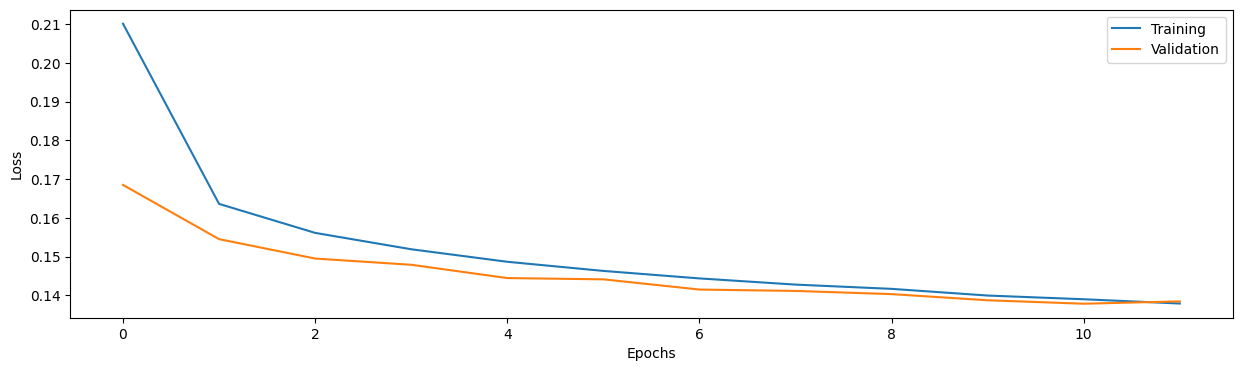

{'F1_score': 0.6655871585468881, 'accuracy': 0.9583333333333334, 'precision': 0.9495781438328647, 'recall': 0.5123563841318014}


In [11]:
import re
import pandas as pd
from io import StringIO
import os
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split

from Dataload import pil_process_image_color, encode, CustomImageDataset
from utils import train_network, pos_weight, test
from metrics import compute_metrics
from sklearn.metrics import confusion_matrix
import torch
import numpy as np
from tqdm import tqdm

# Hyperparameters
batch_size = 512
lr = 0.0001
weight_decay = 0
INPUT_HEIGHT = 248
INPUT_WIDTH = 248
# To remove class 12
#weights = torch.ones(19)
#weights[11] = 0

# Set device to GPU if this is available
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

# Loading filenames and labels
# Assumes data is in folder "Dataset"
DATASET_PATH = "/content/Dataset/COMP5329S1A2Dataset/"
FILENAME_TRAIN = 'train.csv'
FILENAME_TEST = 'test.csv'

with open(DATASET_PATH + FILENAME_TRAIN) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
with open(DATASET_PATH + FILENAME_TEST) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
df_train.to_csv("train_labels_captions.csv")
df_test.to_csv("test_labels_captions.csv")

# To get overview
#print(df_test.describe)

# Defining transforms

resize = transforms.Resize(size=(INPUT_HEIGHT,
        INPUT_WIDTH)) # Trying to resize to (INPUT_HEIGHT,INPUT_WIDTH)

trainTransforms_basic = transforms.Compose(
    [resize,transforms.ToTensor()])
trainTransforms_augment = transforms.Compose(
    [resize,transforms.RandomHorizontalFlip(),transforms.RandomAffine(degrees=90),transforms.ColorJitter(),transforms.ToTensor()])#transforms.RandomCrop(size=124,padding=2,pad_if_needed=True)
testTransforms = transforms.Compose([resize,transforms.ToTensor()])

# Create dataloaders
training_data = CustomImageDataset(df_train,DATASET_PATH+"data/",transform=trainTransforms_basic,transform_aug=trainTransforms_augment,target_transform=encode)
test_data = CustomImageDataset(df_test,DATASET_PATH+"data/",transform=testTransforms,target_transform=None,targets_available=False)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data)

# Setup model
model = CNN().to(device)
#weights = pos_weight(df_train,barplot=False).to(device)
loss = torch.nn.BCEWithLogitsLoss()#weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#optimizer = torch.optim.SGD(model.parameters(),lr=lr)
print('Model initialized.')

# Loading indices for 80/20 split of training data
train_idx = np.load("/content/subset_train_indices.npy")
validation_idx = np.load("/content/validation_indices.npy")
# Subset dataset for train and val
subset_train_dataset = Subset(training_data, train_idx)
validation_dataset = Subset(training_data, validation_idx)
subset_train_loader = DataLoader(subset_train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset)

# Training
log_interval = 100 # How often we print train loss
train_losses, test_losses = train_network(log_interval,model, device, subset_train_loader, validation_loader,optimizer, loss,epochs=12)

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.plot(test_losses,label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.show()

# Testing on validation set and get
test_loss, all_preds, all_targets = test(model, device, validation_loader, loss, target_available=True) # output predictions as tensors
all_preds = np.asarray([np.asarray(tensor.cpu()) for tensor in all_preds])
all_targets = np.asarray([np.asarray(tensor.cpu()) for tensor in all_targets])
metrics = compute_metrics(all_preds,all_targets)
print(metrics)

Model saved to /content/model_21_05_25_lesgo.pt
Model size: 20.749332427978516 MB


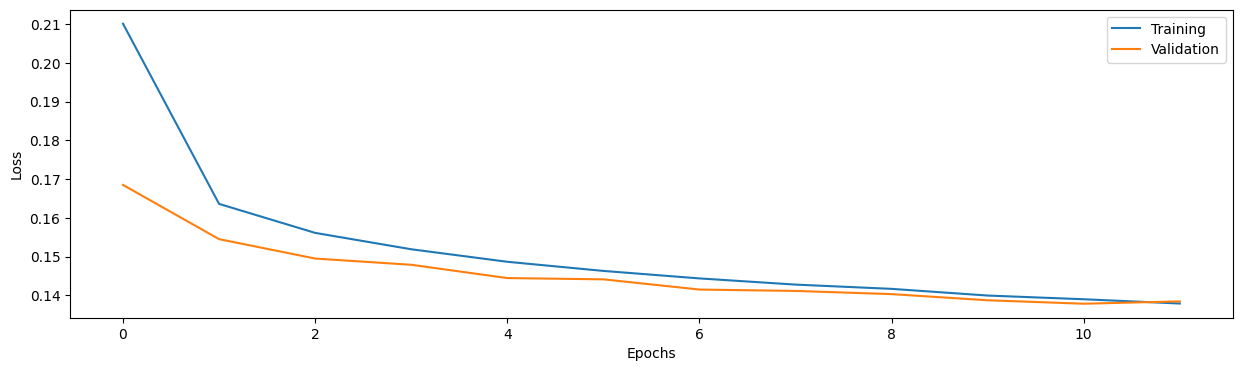

In [12]:
# save model, scores and plot and check size of model is under 100MB
model_name = "21_05_25_lesgo"

def get_model_size_mb(model):
    path = "temp_model.pth"
    torch.save(model.state_dict(), path)
    size_mb = os.path.getsize(path) / (1024 * 1024)
    os.remove(path)
    return size_mb

path_name_model = "/content/model_" + model_name+".pt"
path_name_plot = "/content/model_" + model_name + "loss.png"
path_name_scores = "/content/model_" + model_name + "scores.txt"

torch.save(model.state_dict(), path_name_model)
print(f"Model saved to {path_name_model}")
size_mb = os.path.getsize(path_name_model) / (1024 * 1024)
print(f"Model size: {size_mb} MB")

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.plot(test_losses,label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.savefig(path_name_plot)

import json
with open(path_name_scores, 'w') as file:
     file.write(json.dumps(metrics))

Model initialized.


  0%|          | 0/12 [00:00<?, ?it/s]


Train Epoch: 0 [0/29996 (0%)]	Loss: 0.752274


  8%|▊         | 1/12 [01:17<14:12, 77.49s/it]


Train Epoch: 1 [0/29996 (0%)]	Loss: 0.168433


 17%|█▋        | 2/12 [02:34<12:53, 77.34s/it]


Train Epoch: 2 [0/29996 (0%)]	Loss: 0.160504


 25%|██▌       | 3/12 [03:51<11:33, 77.09s/it]


Train Epoch: 3 [0/29996 (0%)]	Loss: 0.148416


 33%|███▎      | 4/12 [05:08<10:17, 77.17s/it]


Train Epoch: 4 [0/29996 (0%)]	Loss: 0.138980


 42%|████▏     | 5/12 [06:25<08:59, 77.08s/it]


Train Epoch: 5 [0/29996 (0%)]	Loss: 0.145817


 50%|█████     | 6/12 [07:42<07:42, 77.06s/it]


Train Epoch: 6 [0/29996 (0%)]	Loss: 0.151793


 58%|█████▊    | 7/12 [09:00<06:25, 77.17s/it]


Train Epoch: 7 [0/29996 (0%)]	Loss: 0.142279


 67%|██████▋   | 8/12 [10:16<05:08, 77.02s/it]


Train Epoch: 8 [0/29996 (0%)]	Loss: 0.140286


 75%|███████▌  | 9/12 [11:33<03:50, 76.97s/it]


Train Epoch: 9 [0/29996 (0%)]	Loss: 0.129445


 83%|████████▎ | 10/12 [12:50<02:33, 76.97s/it]


Train Epoch: 10 [0/29996 (0%)]	Loss: 0.132408


 92%|█████████▏| 11/12 [14:07<01:17, 77.00s/it]


Train Epoch: 11 [0/29996 (0%)]	Loss: 0.130037


100%|██████████| 10000/10000 [00:34<00:00, 291.22it/s]



Predictions computed for test set.


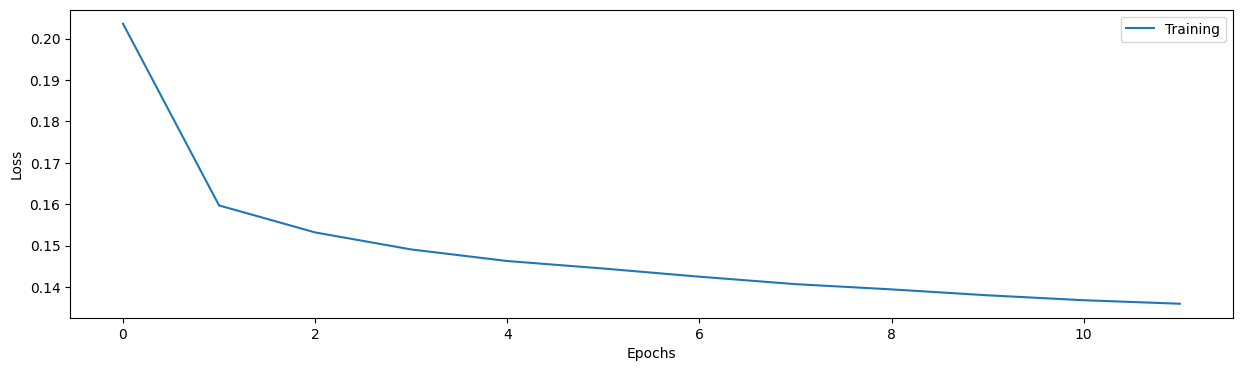

In [13]:
# Training new model on the full dataset
model_full = CNN().to(device)
#weights = pos_weight(df_train,barplot=False).to(device)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_full.parameters(), lr=lr)
print('Model initialized.')
train_losses_full = train_network(log_interval,model_full, device, train_dataloader, test_loader=0,optimizer=optimizer, loss=loss,epochs=12)

plt.figure(figsize=(15,4))
plt.plot(train_losses_full,label="Training")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')

# Compute predictions for true test set
test_pred = test(model_full, device, test_dataloader,loss,target_available=False)

In [15]:
# Convert predictions to csv
from tqdm import tqdm
import numpy as np

def get_class(array):
  return np.where(array > 0.5)[1] +1

def unencode(y_pred):
  labels = []
  for i in tqdm(range(len(y_pred))):
    temp = y_pred[i].cpu()
    temp = np.asarray(temp)
    temp = get_class(temp)
    temp = " ".join(str(item) for item in temp)
    labels.append(temp)
  return labels

#cpu_preds = torch.tensor(val_pred, device =  'cpu')
pred_labels= unencode(test_pred)
pred_df = df_test.copy()
pred_df = pred_df.drop("Caption",axis=1)
pred_df["Labels"] = pred_labels
print("Submission dataframe:")
print(pred_df.describe)
submission_name = "/content/submission.csv"
pred_df.to_csv(submission_name,index=False)
print(f"/nPredictions saved as {submission_name}")

100%|██████████| 10000/10000 [00:00<00:00, 23724.51it/s]

Submission dataframe:
<bound method NDFrame.describe of         ImageID Labels
0     30000.jpg      1
1     30001.jpg      1
2     30002.jpg      1
3     30003.jpg      1
4     30004.jpg      1
...         ...    ...
9995  39995.jpg      1
9996  39996.jpg      1
9997  39997.jpg      1
9998  39998.jpg      1
9999  39999.jpg      1

[10000 rows x 2 columns]>
/nPredictions saved as /content/submission.csv


In [16]:
# Submit predictions
! kaggle competitions submit -c multi-label-classification-competition-2025 -f /content/submission.csv -m "first submission"

100% 117k/117k [00:00<00:00, 130kB/s]
Successfully submitted to Multi-label Classification Competition 2025